<a href="https://colab.research.google.com/drive/1Y7Wluqm2_u9m44GGFLKLct-V1Q8m4-lF?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Author of the Notebook** : **Susnato Dhar** (**Github** **:** https://github.com/susnato)

**This notebook is JAX compatible version of the main notebook which can be found <a href="https://github.com/probml/probml-notebooks/blob/main/notebooks-d2l/finetune_cnn_torch.ipynb">here</a>.
<br>All the credits goes to the author of the main notebook, I just converted it to JAX.**

**I used <a href="https://github.com/n2cholas/jax-resnet">this repository</a> to impelement the pre-trained version of ResNet18 in order to fine tune it!<br>I used the Dataset HotDog VS No HotDog from this <a href="http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip">link</a>.**

In [2]:
#Install Augmax for Image Augmentation 
!pip install git+https://github.com/khdlr/augmax.git -q

#Install the  jax-resnet 
!pip install git+https://github.com/n2cholas/jax-resnet.git -q

     |████████████████████████████████| 184 kB 5.4 MB/s 
     |████████████████████████████████| 136 kB 41.4 MB/s 
     |████████████████████████████████| 72 kB 467 kB/s 


In [3]:
#Download and Extract Data
!wget http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip
!unzip -qq /content/hotdog.zip -d /content/ 

--2022-04-05 12:56:22--  http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip
Resolving d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)... 108.156.127.60
Connecting to d2l-data.s3-accelerate.amazonaws.com (d2l-data.s3-accelerate.amazonaws.com)|108.156.127.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261292301 (249M) [application/zip]
Saving to: ‘hotdog.zip’

hotdog.zip          100%[===================>] 249.19M  67.9MB/s    in 3.8s    

2022-04-05 12:56:26 (65.8 MB/s) - ‘hotdog.zip’ saved [261292301/261292301]



**Imports**

In [6]:
import os
import cv2
import glob
import tqdm
import shutil
import augmax
from typing import Any
from IPython import display 
import matplotlib.pyplot as plt
from skimage.util import montage

In [42]:
import jax 
import jax.numpy as jnp
import jax.random as jrand

key = jrand.PRNGKey(42)

**Load Data**

In [6]:
def load_img(dir, shape=False):
  img = cv2.imread(dir)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  if shape:
    img = cv2.resize(img, shape)
  return jnp.array(img)

train_augs = augmax.Chain(augmax.HorizontalFlip(),
                          #augmax.CenterCrop(200, 200),
                          augmax.Resize(224, 224),
                          augmax.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225]))

test_augs  = augmax.Chain(augmax.HorizontalFlip(),
                          #augmax.CenterCrop(200, 200),
                          augmax.Resize(224, 224),
                          augmax.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225]))

def apply_augs(img, augs, key):
  img = augs(key, img)
  return img


def load_data(motiv):
  assert motiv in ['train', 'test']

  X = []
  Y = []

  #Y=1
  for l in tqdm.tqdm(os.listdir(f'/content/hotdog/{motiv}/hotdog')):
    img = load_img(os.path.join(f'/content/hotdog/{motiv}/hotdog', l))
    img = apply_augs(img, train_augs, key)
    X.append(img)
    Y.append(1)
  #Y=0
  for l in tqdm.tqdm(os.listdir(f'/content/hotdog/{motiv}/not-hotdog')):
    img = load_img(os.path.join(f'/content/hotdog/{motiv}/not-hotdog', l))
    img = apply_augs(img, train_augs, key)
    X.append(img)
    Y.append(0)
  
  X = jnp.array(X)
  Y = jnp.array(Y)

  ix = jnp.arange(X.shape[0])
  ix = jrand.shuffle(key, ix)

  X = X[ix]
  Y = Y[ix]

  return X, Y


In [7]:
%%time

X_train, Y_train = load_data(motiv='train')
X_val, Y_val = load_data(motiv='test')

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]
/usr/local/lib/python3.7/dist-packages/jax/_src/random.py:371: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)
100%|██████████| 400/400 [02:11<00:00,  3.03it/s]


(2000, 224, 224, 3) (2000,)
(800, 224, 224, 3) (800,)
CPU times: user 12min 9s, sys: 27.1 s, total: 12min 36s
Wall time: 15min 45s


Let's view some images(**Because the images are normalized so we need to first convert them to the range of 0 to 1**) in order to view them.

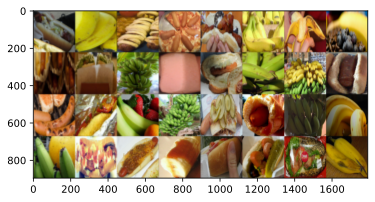

In [41]:
viewable_imgs = X_train[:32]
viewable_imgs = (viewable_imgs-viewable_imgs.min())/(viewable_imgs.max()-viewable_imgs.min())
plt.imshow(montage(viewable_imgs, multichannel=True, grid_shape=(4, 8)));
plt.show();

**Model**


In [3]:
import jax
import optax
import flax.linen as nn
from flax.training import train_state

from jax_resnet import pretrained_resnet
from jax_resnet.common import Sequential

In [4]:
class MyResnet18(nn.Module):
  @nn.compact
  def __call__(self, data):
    ResNet18, variables = pretrained_resnet(18)
    model = ResNet18()
    model = Sequential(model.layers[:-1])
    x = model(data)
    x = nn.Dense(features=1024)(x)
    x = nn.relu(x)
    x = nn.BatchNorm(use_running_average=True)(x)
    x = nn.Dense(features=512)(x)
    x = nn.relu(x)
    x = nn.BatchNorm(use_running_average=True)(x)
    x = nn.Dense(features=128)(x)
    x = nn.relu(x)
    x = nn.BatchNorm(use_running_average=True)(x)
    x = nn.Dense(features=2)(x)

    return x

In [5]:
class TrainState(train_state.TrainState):
  batch_stats: Any


model = MyResnet18()
vars = model.init(key, jnp.ones((1, 224, 224, 3)))
state = TrainState.create(apply_fn=model.apply, params=vars['params'], 
                          batch_stats=vars['batch_stats'], 
                          tx=optax.adam(learning_rate=0.001))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [6]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [7]:
@jax.jit
def compute_metrics(pred, true):
  loss = jnp.mean(optax.softmax_cross_entropy(logits=pred, labels=jax.nn.one_hot(true, num_classes=2)))
  pred = nn.softmax(pred)
  accuracy = jnp.mean(jnp.argmax(pred, -1) == true)

  return {'loss':loss,
          'accuracy' : jnp.mean(accuracy)}
@jax.jit
def eval_step(state, batch):
  variables = {'params': state.params, 'batch_stats': state.batch_stats}
  logits = state.apply_fn(variables, batch['image'], mutable=False)
  return compute_metrics(pred=logits, true=batch['label'])
@jax.jit
def eval_model(state, X_val, Y_val):
  batch_metrics = []
  for i in range(X_val.shape[0]//16): 
    batch = {}
    batch['image'] = jnp.float32(X_val[i*16:(i+1)*16])
    batch['label'] = jnp.float32(Y_val[i*16:(i+1)*16])
    metrics = eval_step(state, batch)
    batch_metrics.append(metrics)

  batch_metrics_np = jax.device_get(batch_metrics)
  batch_loss = []
  batch_acc  = []
  for k in batch_metrics_np[0].keys():
    for metrics in batch_metrics_np:
      batch_loss.append(metrics[k])
      batch_acc.append(metrics[k])

  return jnp.mean(jnp.array(batch_acc))

In [8]:
def train(state, X, Y, epochs, batch_size):
  animator = Animator(xlabel='epoch', xlim=[1, epochs], legend=['train loss', 'train acc', 'test acc'])
  
  def bce_loss(params):
    y_pred, new_model_state = state.apply_fn({'params':params, 'batch_stats':state.batch_stats}, batch['x'], mutable=['batch_stats'])
    y_true = jax.nn.one_hot(batch['y'], num_classes=2)
    loss = optax.softmax_cross_entropy(logits=y_pred, labels=y_true)
    return jnp.mean(loss), (new_model_state, y_pred)

  grad_fn = jax.value_and_grad(bce_loss, has_aux=True)

  for e in range(epochs):
    batch_metrics = []
    for i in range(X.shape[0]//batch_size):
      batch = {}
      batch['x'] = X[i*batch_size:(i+1)*batch_size] 
      batch['y'] = Y[i*batch_size:(i+1)*batch_size]

      aux, grad = grad_fn(state.params)
      batch_loss, (new_model_state, batch_pred) = aux

      state = state.apply_gradients(grads=grad, batch_stats=new_model_state['batch_stats'])
      batch_metrics.append(compute_metrics(pred = state.apply_fn({'params':state.params, 'batch_stats':state.batch_stats}, batch['x']), true = batch['y']))

    batch_metrics_np = jax.device_get(batch_metrics)
    batch_loss = []
    batch_acc  = []
    for k in batch_metrics_np[0].keys():
      for metrics in batch_metrics_np:
        batch_loss.append(metrics[k])
        batch_acc.append(metrics[k])

    animator.add(e+1, (jnp.mean(jnp.array(batch_loss)), jnp.mean(jnp.array(batch_acc)), None))
    acc = eval_model(state, X_val, Y_val)
    animator.add(e+1, (None, None, acc))
 
  return state


**Training**

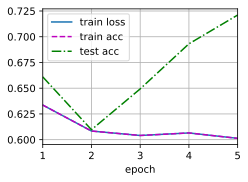

In [9]:
epochs = 5
batch_size = 16
trained_state = train(state, X_train, Y_train, epochs, batch_size)

**Testing The Model**

<ul>
<li>0 = No HotDog</li>
<li>1 = HotDog</li>
</ul>

True Label :  0


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Prediction :  0


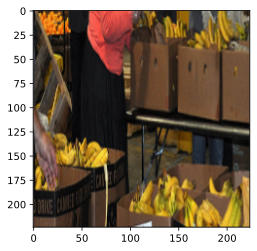

In [43]:
ix = jrand.randint(key, shape=(1, 1), minval=0, maxval=200)

test_img = X_val[ix]
test_label = Y_val[ix]
viewable_img =(test_img[0][0]-test_img[0][0].min())/(test_img[0][0].max()-test_img[0][0].min())

print("True Label : ", test_label[0][0])
print("Prediction : ", jax.device_get(jnp.argmax(jax.nn.softmax(trained_state.apply_fn({'params':trained_state.params, 'batch_stats':trained_state.batch_stats}, test_img[0])))))
plt.imshow(viewable_img);
plt.show();

True Label :  0


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Prediction :  0


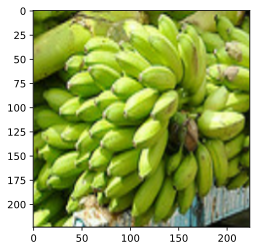

In [44]:
key, _ = jrand.split(key)

ix = jrand.randint(key, shape=(1, 1), minval=0, maxval=200)

test_img = X_val[ix]
test_label = Y_val[ix]
viewable_img =(test_img[0][0]-test_img[0][0].min())/(test_img[0][0].max()-test_img[0][0].min())
print("True Label : ", test_label[0][0])
print("Prediction : ", jax.device_get(jnp.argmax(jax.nn.softmax(trained_state.apply_fn({'params':trained_state.params, 'batch_stats':trained_state.batch_stats}, test_img[0])))))

plt.imshow(viewable_img);
plt.show();


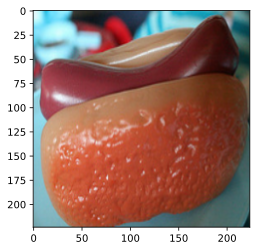

True Label :  1


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Prediction :  1


In [45]:
ix = jnp.array([[140]])

test_img = X_val[ix]
test_label = Y_val[ix]
viewable_img =(test_img[0][0]-test_img[0][0].min())/(test_img[0][0].max()-test_img[0][0].min())

plt.imshow(viewable_img);
plt.show();
print("True Label : ", test_label[0][0])
print("Prediction : ", jax.device_get(jnp.argmax(jax.nn.softmax(trained_state.apply_fn({'params':trained_state.params, 'batch_stats':trained_state.batch_stats}, test_img[0])))))